In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [68]:
trans_df = pd.read_csv('../data/credit_card_fraud_data_v2.csv')

In [29]:
trans_df.shape

(6372620, 11)

In [136]:
trans_df.columns

Index(['Time_Stamp', 'Transaction_Type', 'Amount', 'Client_Id',
       'Client_Old_Balance', 'Cleint_New_Balance', 'Merchant_Id',
       'Merchant_Old_Balance', 'Merchant_New_Balance', 'Is_Fraud',
       'Is_Flagged_Fraud'],
      dtype='object')

In [5]:
trans_df.head()

,Time_Stamp,Transaction_Type,Amount,Client_Id,Client_Old_Balance,Cleint_New_Balance,Merchant_Id,Merchant_Old_Balance,Merchant_New_Balance,Is_Fraud,Is_Flagged_Fraud
0,1,BILL-PAYMENT,9839.64,C494672677,170136.0,160296.36,M582455116,0.0,0.0,0,0
1,1,BILL-PAYMENT,1864.28,C502607876,21249.0,19384.72,C214000796,0.0,0.0,0,0
2,1,PURCHASE,181.00,C633112680,181.0,0.00,M1922059099,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C1993768127,181.0,0.00,M245426835,21182.0,0.0,1,0
4,1,BILL-PAYMENT,11668.14,C1445837831,41554.0,29885.86,M1368211346,0.0,0.0,0,0


(array([1031601.,  480753., 1289783., 1181818., 1275418.,  756576.,
          72058.,  158033.,   55732.,   70848.]),
 array([  1. ,  75.2, 149.4, 223.6, 297.8, 372. , 446.2, 520.4, 594.6,
        668.8, 743. ]),
 <a list of 10 Patch objects>)

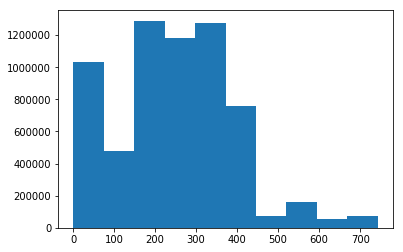

In [146]:
plt.hist(trans_df.Time_Stamp)

In [22]:
trans_df['Time_Stamp'].max()

743

In [137]:
bal_diff = trans_df['Client_Old_Balance'] - trans_df['Cleint_New_Balance']
bal_diff = bal_diff.abs()

In [140]:
(bal_diff - trans_df.Amount).abs().idxmax()

3686583

In [144]:
trans_df.Is_Fraud[trans_df.Is_Flagged_Fraud == 1].sum()

16

In [141]:
trans_df.iloc[3686583]

Time_Stamp                      276
Transaction_Type           PURCHASE
Amount                  9.24455e+07
Client_Id               C1319773702
Client_Old_Balance                0
Cleint_New_Balance                0
Merchant_Id               C22596798
Merchant_Old_Balance        9595.98
Merchant_New_Balance    9.24551e+07
Is_Fraud                          0
Is_Flagged_Fraud                  0
Name: 3686583, dtype: object

### Number of Fraud Cases: 0.3 % !!!!!

In [7]:
trans_df['Is_Fraud'].sum()

18213

### Number of Unique Clients

In [8]:
trans_df['Client_Id'].unique().shape

(952147,)

### Number of Unique Merchants

In [9]:
trans_df['Merchant_Id'].unique().shape

(522360,)

### Range of Trans. Amount Values

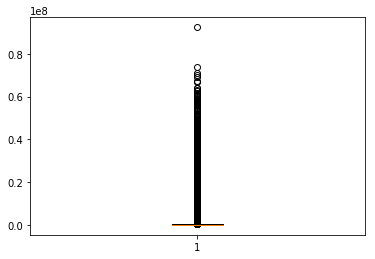

In [11]:
plt.boxplot(trans_df['Amount'])
plt.show()

In [13]:
trans_df['Amount'].max()

92445516.64

In [14]:
trans_df['Amount'].min()

0.0

In [16]:
np.sum(np.abs(trans_df['Is_Fraud'].values - trans_df['Is_Flagged_Fraud'].values))

18197

In [18]:
trans_df['Is_Flagged_Fraud'].sum()

16

### Transaction Type When Fraud

In [15]:
fraud_trans = trans_df[trans_df.Is_Fraud == 1]['Transaction_Type']

In [19]:
np.sum(fraud_trans == 'CASH_OUT')

9116

In [20]:
np.sum(fraud_trans == 'PURCHASE')

9097

### Amount Range When Fraud

In [23]:
amount_fraud = trans_df[trans_df.Is_Fraud == 1]['Amount']

{'boxes': [<matplotlib.lines.Line2D at 0x10f9710b8>],
 'caps': [<matplotlib.lines.Line2D at 0x10f971898>,
 'fliers': [<matplotlib.lines.Line2D at 0x10f9782b0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10f971f28>],
 'whiskers': [<matplotlib.lines.Line2D at 0x10f971208>,
  <matplotlib.lines.Line2D at 0x10f971550>]}

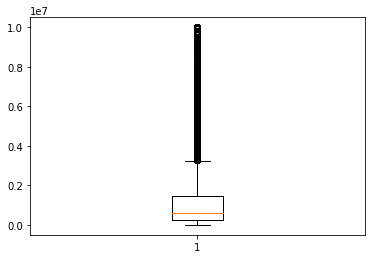

In [24]:
plt.boxplot(amount_fraud)

### Run Basic Logistic Regression 
* Need to create some new features and ignore the time dependence. 

In [134]:
# Change Trans Type to one-hot encoding
model_data = pd.get_dummies(trans_df, columns=['Transaction_Type'])

In [135]:
# Remove columns that don't matter
model_data = model_data.drop(columns=['Time_Stamp', 'Client_Id', 'Merchant_Id', 'Merchant_Old_Balance', 
                         'Merchant_New_Balance', 'Is_Flagged_Fraud'])

In [112]:
# Create new feature 
old_bal = model_data.Client_Old_Balance
purch_amt = model_data.Amount
pctg_bal = purch_amt / old_bal

# Add new feature column
model_data['%_Of_Balance'] = pctg_bal

# Remove any rows where pctg is inf
model_data = model_data[model_data['%_Of_Balance'] != np.inf]
                        
                        
                        
                        

In [115]:
# Combine client balance into one 
abs_bal_diff = model_data.Cleint_New_Balance - model_data.Client_Old_Balance
abs_bal_diff = abs_bal_diff.abs()

# Add new feature column
model_data['abs_bal_diff'] = abs_bal_diff

# Remove columns
model_data = model_data.drop(columns=['Cleint_New_Balance', 'Client_Old_Balance'])

In [116]:
# Standardize Amount and Abs_Bal_Diff columns
model_data['Amount'] = (model_data.Amount - model_data.Amount.mean())/model_data.Amount.std()
model_data['abs_bal_diff'] = (model_data.abs_bal_diff - model_data.abs_bal_diff.mean())/model_data.abs_bal_diff.std()

In [117]:
model_data.head()

,Amount,Is_Fraud,Transaction_Type_BILL-PAYMENT,Transaction_Type_CASH_IN,Transaction_Type_CASH_OUT,Transaction_Type_DEBIT,Transaction_Type_PURCHASE,%_Of_Balance,abs_bal_diff
0,-0.276350,0,1,0,0,0,0,0.057834,-0.208776
1,-0.289043,0,1,0,0,0,0,0.087735,-0.244174
2,-0.291722,1,0,0,0,0,1,1.000000,-0.251645
3,-0.291722,1,0,0,1,0,0,1.000000,-0.251645
4,-0.273440,0,1,0,0,0,0,0.280795,-0.200661


In [118]:
X = model_data.drop(columns='Is_Fraud')
y = model_data.Is_Fraud

In [130]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y)

In [131]:
X_train.max()

Amount                           1.468388e+02
Transaction_Type_BILL-PAYMENT    1.000000e+00
Transaction_Type_CASH_IN         1.000000e+00
Transaction_Type_CASH_OUT        1.000000e+00
Transaction_Type_DEBIT           1.000000e+00
Transaction_Type_PURCHASE        1.000000e+00
%_Of_Balance                     4.000000e+06
abs_bal_diff                     4.413071e+01
dtype: float64

In [133]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model = model.fit(X_train, y_train)

/usr/local/Cellar/python3/3.5.2_3/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').